Notebook to use Twitter API and pull text data from tweets


In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tweepy
import os
from decouple import config

## Dataset 1
This dataset has a list of tweet ids that have been scored, so I'll need to use Tweepy to pull the tweets from the API

In [2]:
consumer_key = config("TWITTER_KEY")
consumer_secret = config("TWITTER_SECRET")
token = config("TWITTER_TOKEN")
secret = config("TOKEN_SECRET")

In [3]:
#pulling list of tweets from first dataset. 
#I'll use this list to pull back the tweet data using the api as they've provided only the tweet ids
corpus = pd.read_csv('./../Data/sarcasm_corpus.csv')
id_list = corpus['author'].to_list()

In [4]:
#https://medium.com/analytics-vidhya/fetch-tweets-using-their-ids-with-tweepy-twitter-api-and-python-ee7a22dcb845
#this function will take in a list of IDs, and my tokens to use tweepy to get everything from the tweet id. It returns
#an array with the json of the tweets from the tweepy status object, and a list of tweet IDs that couldn't be found

def get_tweets(id_list):
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)

    auth.set_access_token(token, secret)
    api = tweepy.API(auth, wait_on_rate_limit_notify = True,wait_on_rate_limit = True)
    tweets=[]
    unavailable = []
    count = 0
 
    for i in id_list:
        if count % 100 == 0:
            print(count)
        count+=1
        data = {}

        try: 
            tweet = api.get_status(i)
            data = tweet._json
            tweets.append(data)
        except:
            unavailable.append(i)
    return tweets, unavailable

In [5]:
tweet_data, none_list = get_tweets(id_list)

0
100
200
300
400
500
600
700
800


Rate limit reached. Sleeping for: 712


900
1000
1100
1200
1300
1400
1500
1600
1700


Rate limit reached. Sleeping for: 707


1800
1900
2000
2100
2200


In [6]:
#After running the function to get the tweet data, let's turn it into a dataframe and take a look
tweet_data = pd.DataFrame(tweet_data)

tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1580 entries, 0 to 1579
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     1580 non-null   object 
 1   id                             1580 non-null   int64  
 2   id_str                         1580 non-null   object 
 3   text                           1580 non-null   object 
 4   truncated                      1580 non-null   bool   
 5   entities                       1580 non-null   object 
 6   source                         1580 non-null   object 
 7   in_reply_to_status_id          1294 non-null   float64
 8   in_reply_to_status_id_str      1294 non-null   object 
 9   in_reply_to_user_id            1294 non-null   float64
 10  in_reply_to_user_id_str        1294 non-null   object 
 11  in_reply_to_screen_name        1294 non-null   object 
 12  user                           1580 non-null   o

In [7]:
#I'll merge corpus(the original labeled dataframe), and the tweet_data from the function on the tweet ID to create corpus_df
corpus_df = corpus.merge(tweet_data,how = 'outer',left_on = ['author'], right_on= ['id'])
#I know that there were unavailable tweets that the function added to none_list. 
#I want to ensure that the null values left over from my outer join, match the none_list
print(len(none_list))

660


In [8]:
#both the none_list and the null values in the dataframe indicate that there are 660 tweets that no longer exist
corpus_df.isnull().sum()

author                              0
 audience                           0
 label                              0
created_at                        660
id                                660
id_str                            660
text                              660
truncated                         660
entities                          660
source                            660
in_reply_to_status_id             946
in_reply_to_status_id_str         946
in_reply_to_user_id               946
in_reply_to_user_id_str           946
in_reply_to_screen_name           946
user                              660
geo                              2198
coordinates                      2198
place                            2190
contributors                     2240
is_quote_status                   660
retweet_count                     660
favorite_count                    660
favorited                         660
retweeted                         660
lang                              660
extended_ent

In [9]:
corpus_df.dtypes

author                             int64
 audience                          int64
 label                             int64
created_at                        object
id                               float64
id_str                            object
text                              object
truncated                         object
entities                          object
source                            object
in_reply_to_status_id            float64
in_reply_to_status_id_str         object
in_reply_to_user_id              float64
in_reply_to_user_id_str           object
in_reply_to_screen_name           object
user                              object
geo                               object
coordinates                       object
place                             object
contributors                      object
is_quote_status                   object
retweet_count                    float64
favorite_count                   float64
favorited                         object
retweeted       

Examination of Null Values

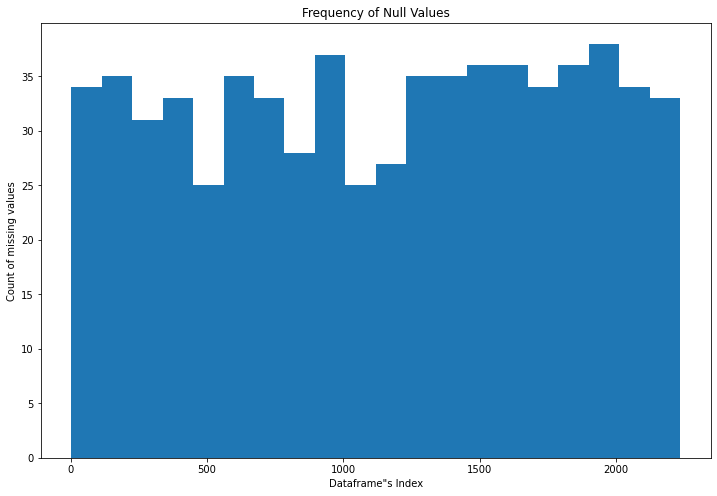

In [10]:
# to make sure the missing values are random, I created a histogram to show where the null values were in relation to the index
plt.figure(figsize = (12,8))
plt.title('Frequency of Null Values')
plt.xlabel('Dataframe"s Index')
plt.ylabel('Count of missing values')
plt.hist(corpus_df[corpus_df['created_at'].isnull()==True].index, bins = 20);
#This looks pretty even across the list

In [11]:
#Now that it looks like the values are missing at random, one last check to see if I can use "created_at" to drop all of the rows
corpus_df[corpus_df['created_at'].isnull()==True].isnull().sum()

author                             0
 audience                          0
 label                             0
created_at                       660
id                               660
id_str                           660
text                             660
truncated                        660
entities                         660
source                           660
in_reply_to_status_id            660
in_reply_to_status_id_str        660
in_reply_to_user_id              660
in_reply_to_user_id_str          660
in_reply_to_screen_name          660
user                             660
geo                              660
coordinates                      660
place                            660
contributors                     660
is_quote_status                  660
retweet_count                    660
favorite_count                   660
favorited                        660
retweeted                        660
lang                             660
extended_entities                660
p

In [12]:
#I've tried pulling the missing tweets directly from the twitter api and they don't exist, and I've shows that they're randomly missing throughout the dataframe, so I can drop them from the analysis
corpus_df.dropna(subset=['created_at'], inplace = True)
corpus_df.reset_index(drop= True, inplace = True)

#I want to know how dropping these rows affects the target variable, the original split is .8/.2, which is maintatined 
corpus_df[corpus_df['created_at'].isnull()==False][' label'].value_counts(normalize=True)

0    0.8
1    0.2
Name:  label, dtype: float64

In [13]:
#the columns names from the original dataset have extra spaces 
corpus_df.rename({' audience':'audience',' label':'label'},axis = 1, inplace = True)

corpus_df.columns

Index(['author', 'audience', 'label', 'created_at', 'id', 'id_str', 'text',
       'truncated', 'entities', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'is_quote_status',
       'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'lang',
       'extended_entities', 'possibly_sensitive',
       'possibly_sensitive_appealable'],
      dtype='object')

In [14]:
#I found this row in the next notebook when trying to understand why the data looked corupted, then I found these return characters that make it hard to open a csv file
corpus_df['text'].loc[77]

'@Karin1Martinez i think its funny that you think i care :p \n#JealousTweet'

In [15]:
#I need to replace the return characters or the csv will save incorrectly
corpus_df['text'] = corpus_df['text'].str.replace("\n","þ")
corpus_df['text'] = corpus_df['text'].str.replace("\r", "|")

In [16]:
#i'm choosing to replace them with other unusual characters
corpus_df['text'].loc[77]

'@Karin1Martinez i think its funny that you think i care :p þ#JealousTweet'

## Dataset 2 
This dataset has just tweets stripped of user handles, wihtout the UserID, so ther rest of the fields I pulled with the first datsaet won't be relevant 

In [17]:
# I'm also using another dataset that has scored sarcasm tweets. I'll add it to corpus_df to enlarge my dataset
#dataset available at https://github.com/EducationalTestingService/sarcasm
test = pd.read_json('../../Capstone/Protected/Data/sarcasm-master/twitter/sarcasm_detection_shared_task_twitter_testing.jsonl', lines = True)
train = pd.read_json('../../Capstone/Protected/Data/sarcasm-master/twitter/sarcasm_detection_shared_task_twitter_training.jsonl', lines = True)

In [18]:
test = test.rename({'response':'text'}, axis = 1).drop(columns = ['context','id'], errors = 'ignore')
train = train.rename({'response':'text'}, axis = 1).drop(columns = ['context','id'], errors = 'ignore')

In [19]:
train.shape

(5000, 2)

In [20]:
test.shape

(1800, 2)

In [21]:
#I don't want to use their same train/test split becasue I have additional data I want to incorporate. Merging everything back together will allow me to make my own splits
corpus_df = pd.concat([corpus_df[['label','text']],test], ignore_index = True)
corpus_df = pd.concat([corpus_df,train], ignore_index = True)

In [22]:
#Now that both datasets are merged, I'll need to adjust the labels column to match 
corpus_df['label'].value_counts()

NOT_SARCASM    3400
SARCASM        3400
0              1264
1               316
Name: label, dtype: int64

In [23]:
corpus_df['label'].replace({"NOT_SARCASM": 0 , "SARCASM" :1}, inplace = True)

In [24]:
#initally the split was .8/.2, the addition of the second dataframe helps balance the two classes
corpus_df['label'].value_counts(normalize = True)

0    0.556563
1    0.443437
Name: label, dtype: float64

In [31]:
#Because this dataset now has all of the tweet data, I'm going to store it in a folder that will not be uploaded to github
corpus_df.to_csv('./../Protected/Data/corpus_with_text.csv', index = False,)

In [32]:
#I also explored pulling tweets with the label sarcasm, and used this function to do so
def get_sarcasm_tweets(hashtag):
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(token, secret)
    api = tweepy.API(auth, wait_on_rate_limit_notify = True,wait_on_rate_limit = True)
    tweets=[]
    for tw in tweepy.Cursor(api.search, q = hashtag,count = 100, lang = 'en',since = "2020-12-20").items():
        
        data = tw._json
        tweets.append(data)
        
    return tweets